In [5]:
import numpy as np
import pandas as pd 
import random

import matplotlib.pyplot as plt
import seaborn as sns

import os 

In [6]:
os.getcwd()

'/Users/lilimatic/sobol_missing'

In [7]:
#random.seed(24)

n=1000
a = 1
b = 2
p=0.9

In [3]:
class dataset:
    def __init__(self,n,p,df):
        #Number of observations
        self.n = n
        #MCAR Bernoulli prob.
        self.p = p
        #data set 
        self.df = df 
        
    #Ishigami function
        #np.random.seed(24)   
    
    def ishigami(self):
        return lambda a, b:  np.sin(self.df['X1']) + a * np.sin(self.df['X2'])**2 + b * (self.df['X3'])**4 * np.sin(self.df['X1']) + np.random.normal(0, 0.01, self.n)
    
    #H-Sample with target from Ishigami function
    
    def h_df(self,a,b):
        self.df['Y'] = self.ishigami()(a,b)
        return self.df['Y']
    
    def picked(self,request,a,b):
        #request are the variables to be randomized, e.g. ['X2','X3']
        newdf = self.df.copy()
        values  = [list(pd.Series(np.random.uniform(0,1,self.n)))]*len(request)
        dictionary = dict(zip(request, values))
        for col, new_values in dictionary.items():
            newdf = newdf.assign(**{col: new_values})
        return newdf
    
    def mcar(self,a,b):
        self.df['Y'] = self.ishigami()(a,b)
        mask = np.random.binomial(size=(self.n,4), n=1, p= self.p) == 0
        self.df[mask] = np.nan 
        cc = self.df.dropna()
        return cc
    
    def mar(self,cond1,cond2):
        cond_x = np.where((self.df['X1'] <0.5) , 1, 0) # & or (self.df['X3'] <0.1)
        omega = (np.random.binomial(size=(self.n,1), n=1, p= p) == 1)  #omega.shape 
        omega = np.reshape(omega,(self.n,))
        condition = omega & (cond_x  ==1) 
        self.df['X3'] = np.where(condition,np.array(self.df['X3']),np.nan)
        return self.df.dropna()
    

In [4]:
df           = pd.DataFrame(np.random.uniform(0,1,size=(n, 3)),columns=['X1','X2','X3'])


In [5]:

mar = dataset(n,p,df).mar(0.2,0.7)

len(mar.dropna())

478

In [6]:
#df           = pd.DataFrame(np.random.uniform(0,1,size=(n, 3)),columns=['X1','X2','X3'])
#df['X1_mis'] = np.where((df['X2'] >0.2) & (df['X3'] <0.7), 1, 0)
#omega = (np.random.binomial(size=(n,1), n=1, p= p) == 1)  #omega.shape
#omega = np.reshape(omega,(100,))
#condition = omega & (df['X1_mis'] ==1)
#df['X1'] = np.where(condition,np.array(df['X1']),np.nan)
#df

In [7]:
def sobol(request,sim):
    sobol_list = []
    for x in range(sim):
        df      = pd.DataFrame(np.random.uniform(0,1,size=(n, 3)),columns=['X1','X2','X3'])
        newdf   = dataset(n,p,df).picked(request,a,b)
        df['Y']    = dataset(n,p,df).h_df(a,b)
        newdf['Y'] = dataset(n,p,newdf).h_df(a,b)
        sobol_list.append((np.cov(df.Y,newdf.Y)/np.var(df.Y))[0][1])
    return sobol_list

Text(0.5, 1.0, '')

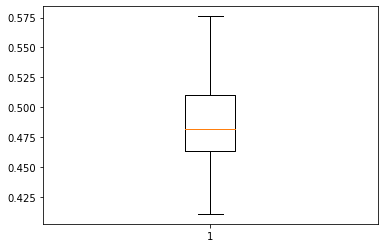

In [8]:
sim = 100
#singletons H-Sample
sobol_X1 = sobol(['X2','X3'],sim)
sobol_X2 = sobol(['X1','X3'],sim)
sobol_X3 = sobol(['X1','X3'],sim)
plt.boxplot(sobol_X1)
plt.title('')

[Text(1, 0, 'X1'), Text(2, 0, 'X2'), Text(3, 0, 'X3')]

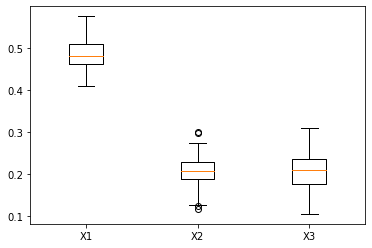

In [9]:
singletons = dict(zip(['X1','X2','X3'],[sobol_X1,sobol_X2,sobol_X3]))

fig, ax = plt.subplots()
ax.boxplot(singletons.values())
ax.set_xticklabels(singletons.keys())


<AxesSubplot:>

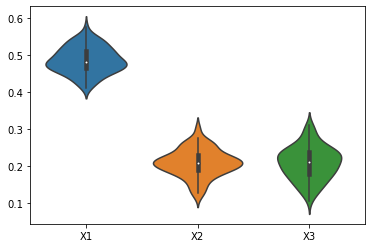

In [10]:
df_singletons = pd.DataFrame(singletons)
sns.violinplot(data=df_singletons)

In [11]:
def sobol_mis(request,sim):
    sobol_list = []
    for x in range(sim):
        df      = pd.DataFrame(np.random.uniform(0,1,size=(n, 3)),columns=['X1','X2','X3'])
        cc = dataset(n,p,df).mar(0.2,0.7)
        newcc   = dataset(len(cc),p,cc).picked(request,a,b)
        cc['Y']    = dataset(len(cc),p,cc).h_df(a,b)
        newcc['Y'] = dataset(len(cc),p,newcc).h_df(a,b)
        sobol_list.append((np.cov(cc.Y,newcc.Y)/np.var(cc.Y))[0][1])
    return sobol_list

In [12]:
df['Y'] = dataset(len(df),p,df).h_df(a,b)
df

,X1,X2,X3,Y
0,0.023086,0.267536,0.087434,0.077010
1,0.260726,0.563215,0.296253,0.559390
2,0.363806,0.976100,0.509429,1.089611
3,0.568141,0.160196,NaN,NaN
4,0.391384,0.044740,0.992855,1.121722
...,...,...,...,...
995,0.195869,0.495372,0.055104,0.425810
996,0.511901,0.492598,NaN,NaN
997,0.629552,0.414726,NaN,NaN
998,0.434860,0.409812,0.540537,0.668198


<ipython-input-3-0158609b3813>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Y'] = self.ishigami()(a,b)
<ipython-input-11-a193a9c51bcf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc['Y']    = dataset(len(cc),p,cc).h_df(a,b)
<ipython-input-3-0158609b3813>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc26e389610>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc26e389cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc26e3892b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc26e3923d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc26e392730>],
 'means': []}

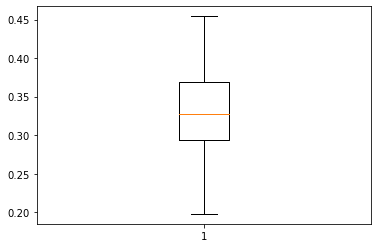

In [13]:
#singletons test 
sobol_X1_mis = sobol_mis(['X2','X3'],sim)
sobol_X2_mis = sobol_mis(['X1','X3'],sim)
sobol_X3_mis = sobol_mis(['X1','X3'],sim)
plt.boxplot(sobol_X1_mis)

[Text(1, 0, 'X1'), Text(2, 0, 'X2'), Text(3, 0, 'X3')]

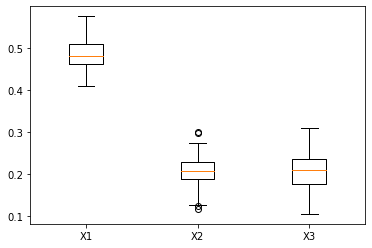

In [14]:
singletons = dict(zip(['X1','X2','X3'],[sobol_X1,sobol_X2,sobol_X3]))

fig, ax = plt.subplots()
ax.boxplot(singletons.values())
ax.set_xticklabels(singletons.keys())


<AxesSubplot:>

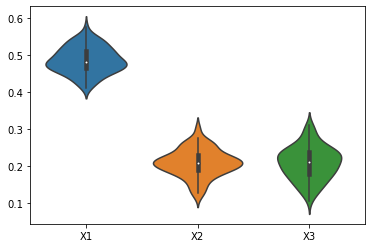

In [15]:
df_singletons = pd.DataFrame(singletons)
sns.violinplot(data=df_singletons)

In [16]:
def sobol_mis(request,sim):
    sobol_list = []
    for x in range(sim):
        df      = pd.DataFrame(np.random.uniform(0,1,size=(n, 3)),columns=['X1','X2','X3'])
        cc = dataset(n,p,df).mcar(a,b)
        newcc   = dataset(len(cc),p,cc).picked(request,a,b)
        newcc['Y'] = dataset(len(cc),p,newcc).h_df(a,b)
        sobol_list.append((np.cov(cc.Y,newcc.Y)/np.var(cc.Y))[0][1])
    return sobol_list

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc26e62d790>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc26e62de50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc26e62d430>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc26e63a550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc26e63a8b0>],
 'means': []}

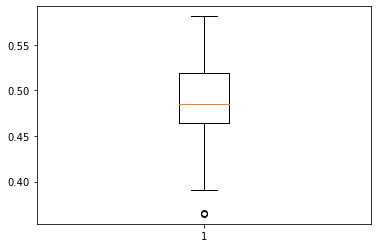

In [17]:
#singletons test 
sobol_X1_mis = sobol_mis(['X2','X3'],sim)
sobol_X2_mis = sobol_mis(['X1','X3'],sim)
sobol_X3_mis = sobol_mis(['X1','X3'],sim)
plt.boxplot(sobol_X1_mis)

In [18]:
singletons_mis = dict(zip(['X1','X2','X3'],[sobol_X1_mis,sobol_X2_mis,sobol_X3_mis]))

[Text(1, 0, 'X1'), Text(2, 0, 'X2'), Text(3, 0, 'X3')]

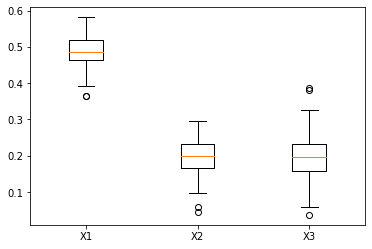

In [19]:
fig, ax = plt.subplots()
ax.boxplot(singletons_mis.values())

ax.set_xticklabels(singletons_mis.keys())

<AxesSubplot:>

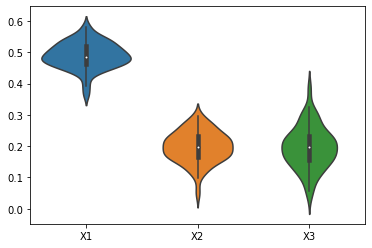

In [20]:
df_singletons_mis = pd.DataFrame(singletons_mis)

sns.violinplot(data=df_singletons_mis)

In [21]:
df_singletons_mis['sample'] = 'cc'
df_singletons['sample'] = 'complete'


cdf = pd.concat([df_singletons, df_singletons_mis],axis=0)  

In [22]:
dd = pd.melt(cdf, id_vars= ['sample'],value_vars=['X1','X2','X3'],var_name='Variable')

#dd

dd = dd.rename(columns={'value':'Sobol index'})

In [23]:
dd

,sample,Variable,Sobol index
0,complete,X1,0.514500
1,complete,X1,0.576071
2,complete,X1,0.509538
3,complete,X1,0.533387
4,complete,X1,0.453257
...,...,...,...
595,cc,X3,0.129051
596,cc,X3,0.215035
597,cc,X3,0.380603
598,cc,X3,0.255278


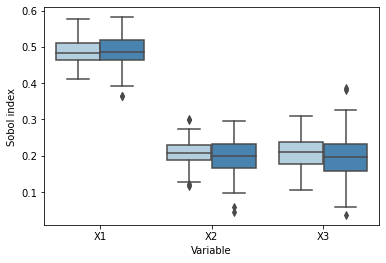

In [24]:
ax = sns.boxplot(x='Variable',y='Sobol index',data=dd,hue='sample',palette="Blues")
ax.legend_.remove()

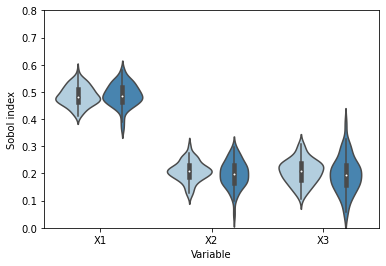

In [25]:
ax = sns.violinplot(x='Variable',y='Sobol index',data=dd,hue='sample',palette="Blues")

ax.legend_.remove()

fig = ax.get_figure()
ax.set(ylim=(0, 0.8))
fig.savefig('violin_cc_true.pdf',transparent=True,bbox_inches='tight')

In [26]:
def sobolplot(n,sim,p):
    sobol_X1 = sobol(['X2','X3'],sim)
    sobol_X2 = sobol(['X1','X3'],sim)
    sobol_X3 = sobol(['X1','X3'],sim)
    singletons = dict(zip(['X1','X2','X3'],[sobol_X1,sobol_X2,sobol_X3]))
    df_singletons = pd.DataFrame(singletons)
    df_singletons['sample'] = 'complete'
    #Missings
    sobol_X1_mis = sobol_mis(['X2','X3'],sim)
    sobol_X2_mis = sobol_mis(['X1','X3'],sim)
    sobol_X3_mis = sobol_mis(['X1','X3'],sim)
    singletons_mis = dict(zip(['X1','X2','X3'],[sobol_X1_mis,sobol_X2_mis,sobol_X3_mis]))
    df_singletons_mis = pd.DataFrame(singletons_mis)
    df_singletons_mis['sample'] = 'cc'
    #Merge
    cdf = pd.concat([df_singletons, df_singletons_mis],axis=0)  
    dd = pd.melt(cdf, id_vars= ['sample'],value_vars=['X1','X2','X3'],var_name='Variable')
    dd = dd.rename(columns={'value':'Sobol index'})
    dd.to_csv('Sobol singleton for p='+str(p)+'.csv')  
    ax = sns.boxplot(x='Variable',y='Sobol index',data=dd,hue='sample',palette="Blues")
    #ax = sns.violinplot(x='Variable',y='Sobol index',data=dd,hue='sample',palette="Blues")
    ax.legend_.remove()
    ax.set(ylim=(-0.05, 0.7))
    fig = ax.get_figure()
    fig.savefig('images/violin_cc_true_mar for p='+str(p)+'.pdf',transparent=True,bbox_inches='tight')
    return fig
    

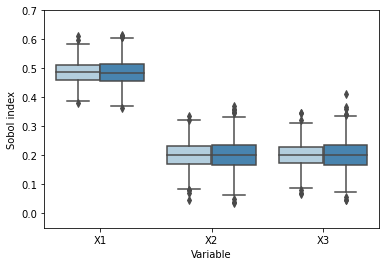

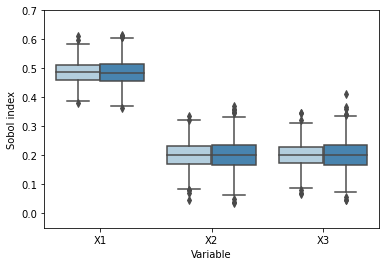

In [27]:
n = 1000
sim = 1000
sobolplot(n,sim,p=0.9)

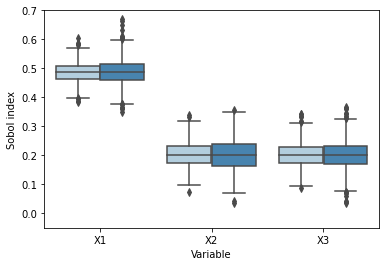

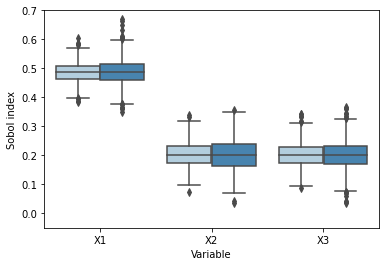

In [28]:
sobolplot(n,sim,p=0.75)

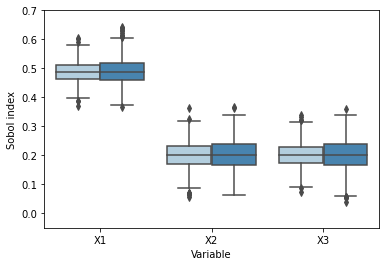

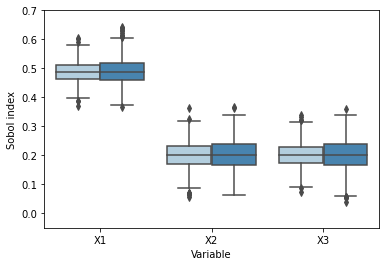

In [29]:
sobolplot(n,sim,p=0.5)